# Prédiction du Diabète
Ce notebook propose un pipeline complet pour la détection du diabète.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Gestion du déséquilibre des classes
from imblearn.over_sampling import SMOTE

# Configuration des graphiques
plt.style.use('default')
sns.set_palette("husl")

In [2]:
df = pd.read_csv('diabetes.csv')

print("📊 Informations sur le dataset :")
print(f"   - Taille : {df.shape[0]} lignes, {df.shape[1]} colonnes")
print(f"   - Variables : {df.shape[1] - 1} features + 1 target")

df.head()

📊 Informations sur le dataset :
   - Taille : 768 lignes, 9 colonnes
   - Variables : 8 features + 1 target


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
print("📋 Informations sur les colonnes :")
df.info()

print("\n📈 Statistiques descriptives :")
df.describe()

📋 Informations sur les colonnes :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

📈 Statistiques descriptives :


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


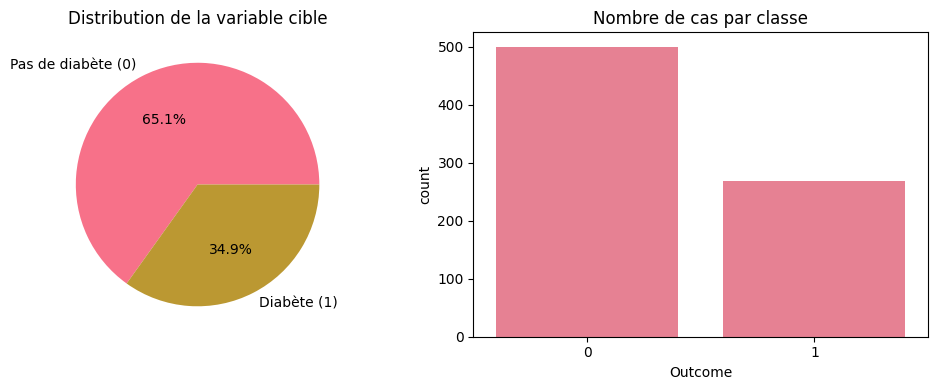

📊 Répartition des classes :
   Pas de diabète: 500 cas (65.1%)
   Diabète: 268 cas (34.9%)


In [5]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
target_counts = df['Outcome'].value_counts()
plt.pie(target_counts.values, labels=['Pas de diabète (0)', 'Diabète (1)'], autopct='%1.1f%%')
plt.title('Distribution de la variable cible')

plt.subplot(1, 2, 2)
sns.countplot(data=df, x='Outcome')
plt.title('Nombre de cas par classe')

plt.tight_layout()
plt.show()

print("📊 Répartition des classes :")
for outcome, count in target_counts.items():
    percentage = (count / len(df)) * 100
    label = "Pas de diabète" if outcome == 0 else "Diabète"
    print(f"   {label}: {count} cas ({percentage:.1f}%)")

In [6]:
zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

print("⚠️ Valeurs zéro problématiques (à traiter comme valeurs manquantes) :")
for col in zero_columns:
    zero_count = (df[col] == 0).sum()
    percentage = (zero_count / len(df)) * 100
    print(f"   {col}: {zero_count} valeurs zéro ({percentage:.1f}%)")

⚠️ Valeurs zéro problématiques (à traiter comme valeurs manquantes) :
   Glucose: 5 valeurs zéro (0.7%)
   BloodPressure: 35 valeurs zéro (4.6%)
   SkinThickness: 227 valeurs zéro (29.6%)
   Insulin: 374 valeurs zéro (48.7%)
   BMI: 11 valeurs zéro (1.4%)


In [7]:
df_processed = df.copy()

for col in zero_columns:
    df_processed[col] = df_processed[col].replace(0, np.nan)

print("🔧 Valeurs manquantes après conversion :")
missing_info = df_processed.isnull().sum()
for col in missing_info[missing_info > 0].index:
    count = missing_info[col]
    percentage = (count / len(df_processed)) * 100
    print(f"   {col}: {count} valeurs manquantes ({percentage:.1f}%)")

🔧 Valeurs manquantes après conversion :
   Glucose: 5 valeurs manquantes (0.7%)
   BloodPressure: 35 valeurs manquantes (4.6%)
   SkinThickness: 227 valeurs manquantes (29.6%)
   Insulin: 374 valeurs manquantes (48.7%)
   BMI: 11 valeurs manquantes (1.4%)


In [8]:
print("🔧 Imputation des valeurs manquantes avec la médiane...")

for col in zero_columns:
    if df_processed[col].isnull().sum() > 0:
        median_value = df_processed[col].median()
        df_processed[col].fillna(median_value, inplace=True)
        print(f"   {col}: médiane = {median_value:.1f}")

print(f"   Total valeurs manquantes : {df_processed.isnull().sum().sum()}")

🔧 Imputation des valeurs manquantes avec la médiane...
   Glucose: médiane = 117.0
   BloodPressure: médiane = 72.0
   SkinThickness: médiane = 29.0
   Insulin: médiane = 125.0
   BMI: médiane = 32.3
   Total valeurs manquantes : 0


In [9]:
print("⚡ Création de nouvelles features...")

def categorize_bmi(bmi):
    if bmi < 18.5:
        return 0  # Sous-poids
    elif bmi < 25:
        return 1  # Normal
    elif bmi < 30:
        return 2  # Surpoids
    else:
        return 3  # Obésité

df_processed['BMI_Category'] = df_processed['BMI'].apply(categorize_bmi)

def categorize_age(age):
    if age < 30:
        return 0  # Jeune
    elif age < 50:
        return 1  # Adulte
    else:
        return 2  # Senior

df_processed['Age_Group'] = df_processed['Age'].apply(categorize_age)

def categorize_glucose(glucose):
    if glucose < 100:
        return 0  # Normal
    elif glucose < 126:
        return 1  # Pré-diabète
    else:
        return 2  # Diabète

df_processed['Glucose_Level'] = df_processed['Glucose'].apply(categorize_glucose)

df_processed['BMI_Age'] = df_processed['BMI'] * df_processed['Age']
df_processed['Glucose_BMI'] = df_processed['Glucose'] * df_processed['BMI']

# Indicateur grossesses multiples
df_processed['High_Pregnancies'] = (df_processed['Pregnancies'] >= 4).astype(int)

new_features = ['BMI_Category', 'Age_Group', 'Glucose_Level', 'BMI_Age', 'Glucose_BMI', 'High_Pregnancies']
for feature in new_features:
    print(f"   ✓ {feature}")

print(f"\n📊 Nouvelles dimensions : {df_processed.shape}")

⚡ Création de nouvelles features...
   ✓ BMI_Category
   ✓ Age_Group
   ✓ Glucose_Level
   ✓ BMI_Age
   ✓ Glucose_BMI
   ✓ High_Pregnancies

📊 Nouvelles dimensions : (768, 15)


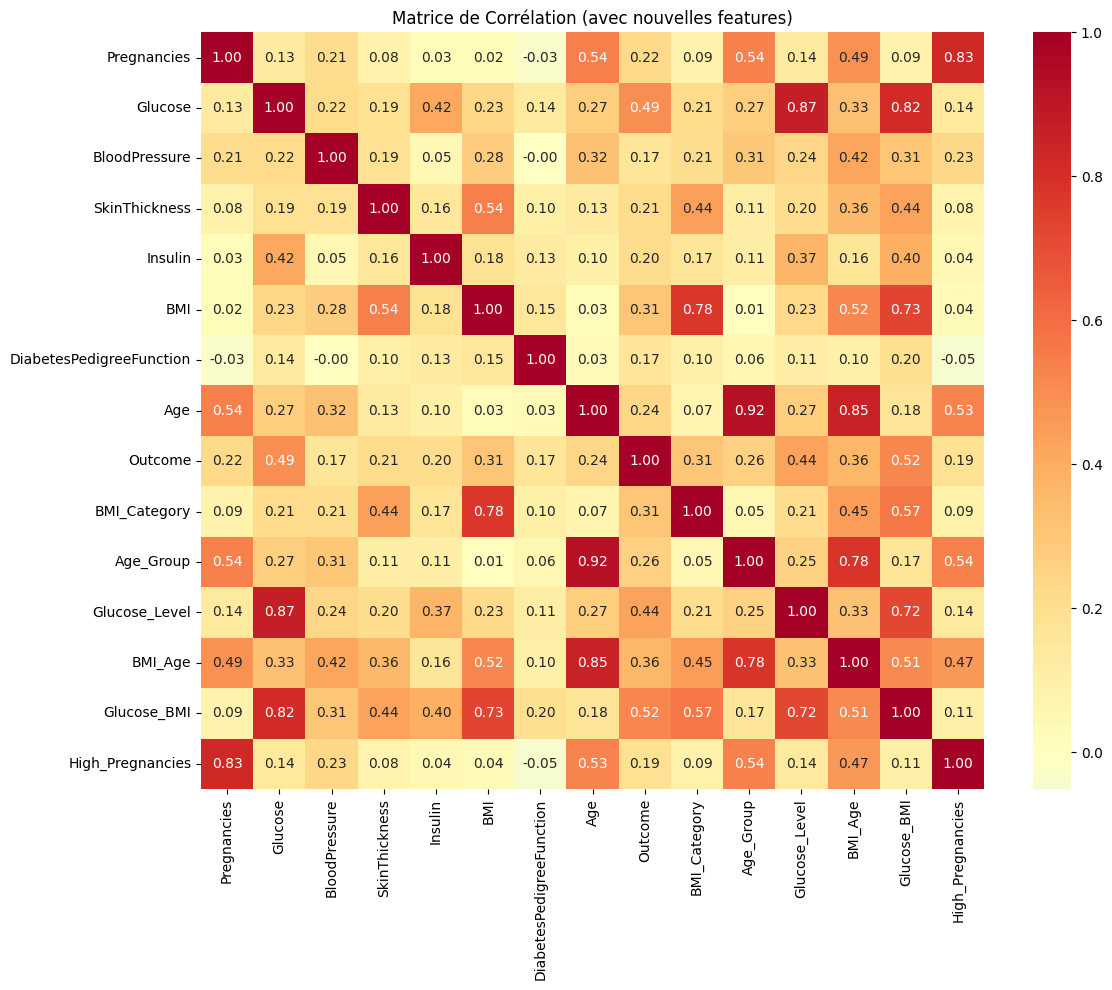

🎯 Corrélation avec la variable cible (Outcome) :

Top 5 features les plus corrélées :
   Glucose_BMI: 0.520
   Glucose: 0.493
   Glucose_Level: 0.436
   BMI_Age: 0.363
   BMI: 0.312

Top 3 features les moins corrélées :
   High_Pregnancies: 0.192
   DiabetesPedigreeFunction: 0.174
   BloodPressure: 0.166


In [10]:
plt.figure(figsize=(12, 10))
correlation_matrix = df_processed.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', fmt='.2f', center=0)
plt.title('Matrice de Corrélation (avec nouvelles features)')
plt.tight_layout()
plt.show()

target_corr = correlation_matrix['Outcome'].drop('Outcome').sort_values(key=abs, ascending=False)

print("🎯 Corrélation avec la variable cible (Outcome) :")
print("\nTop 5 features les plus corrélées :")
for feature, corr in target_corr.head().items():
    print(f"   {feature}: {corr:.3f}")

print("\nTop 3 features les moins corrélées :")
for feature, corr in target_corr.tail(3).items():
    print(f"   {feature}: {corr:.3f}")

In [12]:
X = df_processed.drop('Outcome', axis=1)
y = df_processed['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("⚖️ Normalisation effectuée avec StandardScaler")

# Gestion du déséquilibre des classes avec SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("\n⚖️ Équilibrage des classes avec SMOTE :")
print(f"   Avant: {Counter(y_train)}")
print(f"   Après: {Counter(y_train_balanced)}")

⚖️ Normalisation effectuée avec StandardScaler

⚖️ Équilibrage des classes avec SMOTE :
   Avant: Counter({0: 400, 1: 214})
   Après: Counter({0: 400, 1: 400})


In [15]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

results = {}
cv_scores = {}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"📈 {name}...")
    
    cv_score = cross_val_score(model, X_train_balanced, y_train_balanced, cv=cv, scoring='roc_auc')
    cv_scores[name] = cv_score
    
    model.fit(X_train_balanced, y_train_balanced)
    
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'cv_auc_mean': cv_score.mean(),
        'cv_auc_std': cv_score.std()
    }
    
    print(f"   ✓ CV AUC: {cv_score.mean():.4f} (±{cv_score.std():.4f})")
    print(f"   ✓ Test AUC: {auc:.4f}")
    print()

📈 Random Forest...
   ✓ CV AUC: 0.8979 (±0.0256)
   ✓ Test AUC: 0.8181

📈 Gradient Boosting...
   ✓ CV AUC: 0.8979 (±0.0256)
   ✓ Test AUC: 0.8181

📈 Gradient Boosting...
   ✓ CV AUC: 0.8767 (±0.0193)
   ✓ Test AUC: 0.8170

📈 SVM...
   ✓ CV AUC: 0.8721 (±0.0306)
   ✓ Test AUC: 0.8243

📈 Logistic Regression...
   ✓ CV AUC: 0.8466 (±0.0105)
   ✓ Test AUC: 0.8289

   ✓ CV AUC: 0.8767 (±0.0193)
   ✓ Test AUC: 0.8170

📈 SVM...
   ✓ CV AUC: 0.8721 (±0.0306)
   ✓ Test AUC: 0.8243

📈 Logistic Regression...
   ✓ CV AUC: 0.8466 (±0.0105)
   ✓ Test AUC: 0.8289



In [16]:
results_df = pd.DataFrame({
    'Modèle': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results],
    'Precision': [results[model]['precision'] for model in results],
    'Recall': [results[model]['recall'] for model in results],
    'F1-Score': [results[model]['f1'] for model in results],
    'AUC-ROC': [results[model]['auc'] for model in results],
    'CV AUC (mean)': [results[model]['cv_auc_mean'] for model in results],
    'CV AUC (std)': [results[model]['cv_auc_std'] for model in results]
})

results_df = results_df.sort_values('AUC-ROC', ascending=False)

print("🏆 RÉSULTATS FINAUX - Classement des modèles :")
print("=" * 80)
print(results_df.round(4).to_string(index=False))

best_model_name = results_df.iloc[0]['Modèle']
best_auc = results_df.iloc[0]['AUC-ROC']

print(f"\n🥇 MEILLEUR MODÈLE: {best_model_name}")
print(f"   AUC-ROC: {best_auc:.4f}")
print(f"   Accuracy: {results_df.iloc[0]['Accuracy']:.4f}")
print(f"   Recall: {results_df.iloc[0]['Recall']:.4f}")

🏆 RÉSULTATS FINAUX - Classement des modèles :
             Modèle  Accuracy  Precision  Recall  F1-Score  AUC-ROC  CV AUC (mean)  CV AUC (std)
Logistic Regression    0.7468     0.6230  0.7037    0.6609   0.8289         0.8466        0.0105
                SVM    0.7468     0.6119  0.7593    0.6777   0.8243         0.8721        0.0306
      Random Forest    0.7273     0.6034  0.6481    0.6250   0.8181         0.8979        0.0256
  Gradient Boosting    0.7143     0.5833  0.6481    0.6140   0.8170         0.8767        0.0193

🥇 MEILLEUR MODÈLE: Logistic Regression
   AUC-ROC: 0.8289
   Accuracy: 0.7468
   Recall: 0.7037


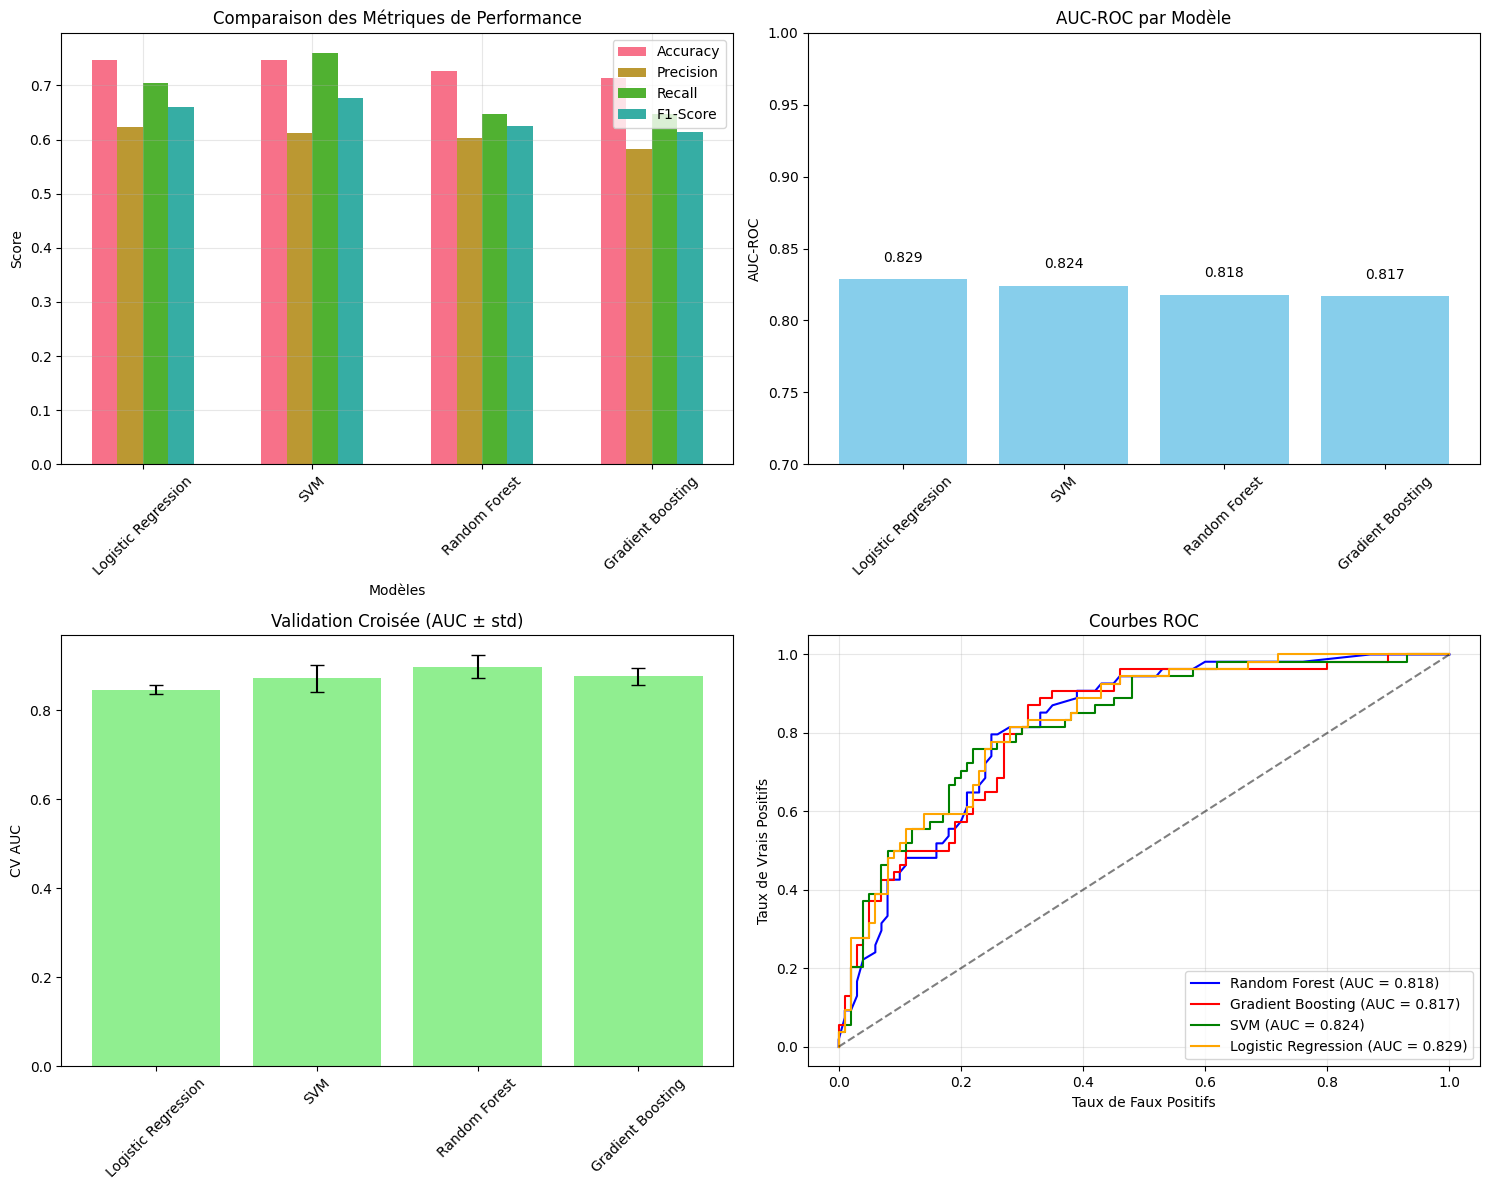

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
x_pos = np.arange(len(results_df))

ax1 = axes[0, 0]
width = 0.15
for i, metric in enumerate(metrics[:-1]):
    ax1.bar(x_pos + i*width, results_df[metric], width, label=metric)
ax1.set_xlabel('Modèles')
ax1.set_ylabel('Score')
ax1.set_title('Comparaison des Métriques de Performance')
ax1.set_xticks(x_pos + width*1.5)
ax1.set_xticklabels(results_df['Modèle'], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
bars = ax2.bar(results_df['Modèle'], results_df['AUC-ROC'], color='skyblue')
ax2.set_title('AUC-ROC par Modèle')
ax2.set_ylabel('AUC-ROC')
ax2.set_ylim(0.7, 1.0)
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom')
plt.setp(ax2.get_xticklabels(), rotation=45)

ax3 = axes[1, 0]
cv_means = [results[model]['cv_auc_mean'] for model in results_df['Modèle']]
cv_stds = [results[model]['cv_auc_std'] for model in results_df['Modèle']]
ax3.bar(results_df['Modèle'], cv_means, yerr=cv_stds, capsize=5, color='lightgreen')
ax3.set_title('Validation Croisée (AUC ± std)')
ax3.set_ylabel('CV AUC')
plt.setp(ax3.get_xticklabels(), rotation=45)

ax4 = axes[1, 1]
colors = ['blue', 'red', 'green', 'orange']
for i, (name, result) in enumerate(results.items()):
    model = result['model']
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax4.plot(fpr, tpr, color=colors[i], 
             label=f'{name} (AUC = {result["auc"]:.3f})')

ax4.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax4.set_xlabel('Taux de Faux Positifs')
ax4.set_ylabel('Taux de Vrais Positifs')
ax4.set_title('Courbes ROC')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

🔍 ANALYSE DÉTAILLÉE - Logistic Regression
📊 Rapport de Classification :
                precision    recall  f1-score   support

Pas de diabète       0.83      0.77      0.80       100
       Diabète       0.62      0.70      0.66        54

      accuracy                           0.75       154
     macro avg       0.73      0.74      0.73       154
  weighted avg       0.76      0.75      0.75       154



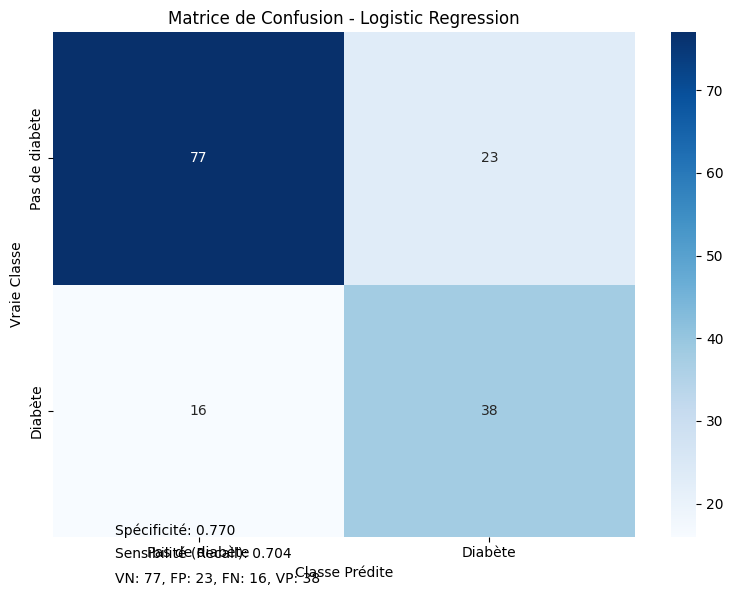

In [18]:
best_model = results[best_model_name]['model']
y_pred_best = best_model.predict(X_test_scaled)
y_pred_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]

print(f"🔍 ANALYSE DÉTAILLÉE - {best_model_name}")
print("=" * 50)

print("📊 Rapport de Classification :")
print(classification_report(y_test, y_pred_best, 
                          target_names=['Pas de diabète', 'Diabète']))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pas de diabète', 'Diabète'],
            yticklabels=['Pas de diabète', 'Diabète'])
plt.title(f'Matrice de Confusion - {best_model_name}')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')

tn, fp, fn, tp = cm.ravel()
plt.figtext(0.15, 0.02, f'VN: {tn}, FP: {fp}, FN: {fn}, VP: {tp}', fontsize=10)
plt.figtext(0.15, 0.06, f'Sensibilité (Recall): {tp/(tp+fn):.3f}', fontsize=10)
plt.figtext(0.15, 0.10, f'Spécificité: {tn/(tn+fp):.3f}', fontsize=10)

plt.tight_layout()
plt.show()

In [19]:
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title(f'Importance des Features - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    print("🎯 TOP 5 Features les plus importantes :")
    for i, row in feature_importance.head().iterrows():
        print(f"   {row['feature']}: {row['importance']:.4f}")
else:
    print(f"ℹ️ {best_model_name} ne fournit pas d'importance des features")

ℹ️ Logistic Regression ne fournit pas d'importance des features


In [20]:
import joblib
from datetime import datetime

import os
os.makedirs('models', exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

model_filename = f'models/best_diabetes_model_{timestamp}.pkl'
joblib.dump(best_model, model_filename)

scaler_filename = f'models/scaler_{timestamp}.pkl'
joblib.dump(scaler, scaler_filename)

columns_filename = f'models/feature_columns_{timestamp}.pkl'
joblib.dump(list(X.columns), columns_filename)

metadata = {
    'model_name': best_model_name,
    'model_params': str(best_model.get_params()),
    'features': list(X.columns),
    'performance': {
        'accuracy': results[best_model_name]['accuracy'],
        'precision': results[best_model_name]['precision'],
        'recall': results[best_model_name]['recall'],
        'f1_score': results[best_model_name]['f1'],
        'auc_roc': results[best_model_name]['auc'],
        'cv_auc_mean': results[best_model_name]['cv_auc_mean'],
        'cv_auc_std': results[best_model_name]['cv_auc_std']
    },
    'training_date': datetime.now().isoformat(),
    'data_shape': df_processed.shape,
    'preprocessing_steps': [
        'Imputation des valeurs manquantes avec médiane',
        'Feature engineering (BMI_Category, Age_Group, etc.)',
        'Normalisation StandardScaler',
        'Équilibrage SMOTE'
    ]
}

metadata_filename = f'models/model_metadata_{timestamp}.pkl'
joblib.dump(metadata, metadata_filename)

print("💾 SAUVEGARDE COMPLÉTÉE !")
print(f"   📁 Modèle: {model_filename}")
print(f"   📁 Scaler: {scaler_filename}")
print(f"   📁 Features: {columns_filename}")
print(f"   📁 Métadonnées: {metadata_filename}")

print(f"\n🎯 RÉSUMÉ FINAL :")
print(f"   Meilleur modèle: {best_model_name}")
print(f"   Performance AUC-ROC: {best_auc:.4f}")
print(f"   Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"   Recall (crucial en médical): {results[best_model_name]['recall']:.4f}")
print(f"   Features utilisées: {len(X.columns)}")

💾 SAUVEGARDE COMPLÉTÉE !
   📁 Modèle: models/best_diabetes_model_20250809_153825.pkl
   📁 Scaler: models/scaler_20250809_153825.pkl
   📁 Features: models/feature_columns_20250809_153825.pkl
   📁 Métadonnées: models/model_metadata_20250809_153825.pkl

🎯 RÉSUMÉ FINAL :
   Meilleur modèle: Logistic Regression
   Performance AUC-ROC: 0.8289
   Accuracy: 0.7468
   Recall (crucial en médical): 0.7037
   Features utilisées: 14


In [21]:
# Fonction pour faire une prédiction sur un nouveau patient
def predict_diabetes(patient_data, model, scaler, feature_columns):
    
    df_patient = pd.DataFrame([patient_data])
    
    df_patient['BMI_Category'] = df_patient['BMI'].apply(categorize_bmi)
    df_patient['Age_Group'] = df_patient['Age'].apply(categorize_age)
    df_patient['Glucose_Level'] = df_patient['Glucose'].apply(categorize_glucose)
    df_patient['BMI_Age'] = df_patient['BMI'] * df_patient['Age']
    df_patient['Glucose_BMI'] = df_patient['Glucose'] * df_patient['BMI']
    df_patient['High_Pregnancies'] = (df_patient['Pregnancies'] >= 4).astype(int)
    
    for col in feature_columns:
        if col not in df_patient.columns:
            df_patient[col] = 0
    
    df_patient = df_patient[feature_columns]
    
    patient_scaled = scaler.transform(df_patient)
    
    prediction = model.predict(patient_scaled)[0]
    probability = model.predict_proba(patient_scaled)[0, 1]
    
    return {
        'prediction': int(prediction),
        'probability': float(probability),
        'risk_level': 'Élevé' if probability > 0.7 else 'Modéré' if probability > 0.3 else 'Faible'
    }

print("🧪 TESTS DE PRÉDICTION")
print("=" * 40)

# Exemple 1: Patient à faible risque
patient_1 = {
    'Pregnancies': 1,
    'Glucose': 85,
    'BloodPressure': 66,
    'SkinThickness': 29,
    'Insulin': 0,
    'BMI': 26.6,
    'DiabetesPedigreeFunction': 0.351,
    'Age': 31
}

result_1 = predict_diabetes(patient_1, best_model, scaler, list(X.columns))
print(f"👤 Patient 1 (profil jeune, paramètres normaux):")
print(f"   Prédiction: {'Diabète' if result_1['prediction'] == 1 else 'Pas de diabète'}")
print(f"   Probabilité: {result_1['probability']:.3f}")
print(f"   Niveau de risque: {result_1['risk_level']}")
print()

# Exemple 2: Patient à risque élevé
patient_2 = {
    'Pregnancies': 6,
    'Glucose': 148,
    'BloodPressure': 72,
    'SkinThickness': 35,
    'Insulin': 0,
    'BMI': 33.6,
    'DiabetesPedigreeFunction': 0.627,
    'Age': 50
}

result_2 = predict_diabetes(patient_2, best_model, scaler, list(X.columns))
print(f"👤 Patient 2 (profil à risque élevé):")
print(f"   Prédiction: {'Diabète' if result_2['prediction'] == 1 else 'Pas de diabète'}")
print(f"   Probabilité: {result_2['probability']:.3f}")
print(f"   Niveau de risque: {result_2['risk_level']}")
print()

print("✅ Tests de prédiction terminés !")

🧪 TESTS DE PRÉDICTION
👤 Patient 1 (profil jeune, paramètres normaux):
   Prédiction: Pas de diabète
   Probabilité: 0.116
   Niveau de risque: Faible

👤 Patient 2 (profil à risque élevé):
   Prédiction: Diabète
   Probabilité: 0.931
   Niveau de risque: Élevé

✅ Tests de prédiction terminés !
